### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [177]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [178]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
    tf.random.set_seed(2)
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [179]:
## Import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D

# multivariate data preparation
from numpy import array, hstack

In [180]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Analysis import print_desc_statistic
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
from DEV_Common_Data_Preprocessing import resample_by_last, find_outlier_Usages, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [181]:
## Init_config
SEED = 42

np.random.seed(SEED)
# tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [182]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-01-05 19:40:57.343216
2024 / 1 / 5
19 : 40


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [183]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
# print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', index_col = 0)
df_kdhc_heat = df_kdhc_heat[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday'
                             ,'HOUR'
                            #  , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                            #  , 'humidity'
                            #  , 'rainfall'
                            #  , 'snowfall', 'snowfall_3hr'
                            #  , 'wind_speed', 'wind_direction'
                            #  , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                            #  , 'visual_range'
                             , 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
                             , 'KANGNAM'
                             , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
                             , 'KIMHAE', 'DAEGU', 'YANGSAN'
                             , 'GWANGJU_JEONNAM']]
## 어디서 중복 생긴건지 확인 필요
df_kdhc_heat = df_kdhc_heat.drop_duplicates()

df_kdhc_heat['METER_DATE'] = pd.to_datetime(df_kdhc_heat['METER_DATE'])
df_dt = df_kdhc_heat['METER_DATE']

## 추출된 "DATE"로부터 Week를 계산
# df_kdhc_heat['WEEK'] = df_kdhc_heat['METER_DATE'].dt.strftime('%G-%V') 

for i in range(0, len(df_kdhc_heat)):
    ## 중간에 Code화 되지 않은 rest_YN Data가 있다.
    if((str(df_kdhc_heat['rest_YN'].iloc[i]) == 'N') | (df_kdhc_heat['rest_YN'].iloc[i] == '0')):
        df_kdhc_heat['rest_YN'].iloc[i] = 0
    if((str(df_kdhc_heat['rest_YN'].iloc[i]) == 'Y') | (df_kdhc_heat['rest_YN'].iloc[i] == '1')):
        df_kdhc_heat['rest_YN'].iloc[i] = 1

    ## 중간에 이상하게 처리된 KASI Data가 있다.
    if((str(df_kdhc_heat['dist_from_holiday'].iloc[i]) == '제헌절')
        | (str(df_kdhc_heat['dist_from_holiday'].iloc[i]) == '한글날')):
        df_kdhc_heat['dist_from_holiday'].iloc[i] = 0

df_kdhc_heat['rest_YN'] = df_kdhc_heat['rest_YN'].astype('int64')
df_kdhc_heat['dist_from_holiday'] = df_kdhc_heat['rest_YN'].astype('int64')

print(df_kdhc_heat.columns)
# df_kdhc_heat

Index(['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'rest_YN',
       'dist_from_holiday', 'HOUR', 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG',
       'KANGNAM', 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON',
       'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG', 'KIMHAE',
       'DAEGU', 'YANGSAN', 'GWANGJU_JEONNAM'],
      dtype='object')


In [274]:
## 휴일일 때
df_raw = df_kdhc_heat[df_kdhc_heat['rest_YN'] == 0]

## 평일일 때
# df_raw = df_kdhc_heat[df_kdhc_heat['rest_YN'] == 1]

## Target 지역 설정
# col_tar = 'PAJU'
# col_tar = 'BUNDANG'
# col_tar = 'KANGNAM'
# col_tar = 'CHEONGJU'
col_tar = 'DAEGU'

# df_kdhc_heat = df_kdhc_heat[[col_tar]]
df_raw = df_raw[['YEAR', 'MONTH', 'DAY', 'rest_YN','code_day_of_the_week', 'dist_from_holiday'
                , 'HOUR'
                , 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
                , 'KANGNAM', 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
                , 'KIMHAE', 'DAEGU', 'YANGSAN'
                , 'GWANGJU_JEONNAM']]
df_raw

,YEAR,MONTH,DAY,rest_YN,code_day_of_the_week,dist_from_holiday,HOUR,PAJU,GOYANG,SAMSONG,...,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019,10,1,0,1,0,1,20,73.0000000000,8.0000000000,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019,10,1,0,1,0,2,15,65.0000000000,12.0000000000,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019,10,1,0,1,0,3,14,58.0000000000,12.0000000000,...,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
6,2019,10,1,0,1,0,4,14,56.0000000000,9.0000000000,...,38.0000000000,13.0000000000,18,0.5000000000,11,16.0000000000,6,13.0000000000,8,2
8,2019,10,1,0,1,0,5,14,48.0000000000,11.0000000000,...,42.0000000000,13.0000000000,15,0.5000000000,11,18.0000000000,6,13.0000000000,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27297,2022,9,30,0,4,0,19,34,76.0000000000,45.0000000000,...,65.0000000000,37.0000000000,61,11.0000000000,30,48.0000000000,10,31.0000000000,16,7
27298,2022,9,30,0,4,0,20,41,81.0000000000,44.0000000000,...,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022,9,30,0,4,0,21,40,90.0000000000,46.0000000000,...,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022,9,30,0,4,0,22,37,95.0000000000,39.0000000000,...,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6


In [275]:
data = np.array(df_raw[col_tar])
conv1d_filter = np.array([1,2])

In [276]:
def Conv1D_Numpy(Seq, Kernel):
    kernel_size = len(Kernel)
    Length = len(Seq)
    
    output = []
    for i in range(Length-kernel_size+1): 
        conv = np.dot(Seq[i:i+kernel_size], Kernel)
        print(Seq[i:i+kernel_size], "*", Kernel, "=> ", conv)

        output.append(conv)

    output = np.array(output)
    
    return output

In [277]:
output = Conv1D_Numpy(data, conv1d_filter)
output

[19. 16.] * [1 2] =>  51.0
[16. 15.] * [1 2] =>  46.0
[15. 13.] * [1 2] =>  41.0
[13. 13.] * [1 2] =>  39.0
[13. 17.] * [1 2] =>  47.0
[17. 31.] * [1 2] =>  79.0
[31. 46.] * [1 2] =>  123.0
[46. 35.] * [1 2] =>  116.0
[35. 31.] * [1 2] =>  97.0
[31. 30.] * [1 2] =>  91.0
[30. 29.] * [1 2] =>  88.0
[29. 28.] * [1 2] =>  85.0
[28. 26.] * [1 2] =>  80.0
[26. 25.] * [1 2] =>  76.0
[25. 30.] * [1 2] =>  85.0
[30. 24.] * [1 2] =>  78.0
[24. 27.] * [1 2] =>  78.0
[27. 33.] * [1 2] =>  93.0
[33. 39.] * [1 2] =>  111.0
[39. 40.] * [1 2] =>  119.0
[40. 41.] * [1 2] =>  122.0
[41. 37.] * [1 2] =>  115.0
[37. 36.] * [1 2] =>  109.0
[36. 27.] * [1 2] =>  90.0
[27. 18.] * [1 2] =>  63.0
[18. 19.] * [1 2] =>  56.0
[19. 15.] * [1 2] =>  49.0
[15. 17.] * [1 2] =>  49.0
[17. 22.] * [1 2] =>  61.0
[22. 30.] * [1 2] =>  82.0
[30. 51.] * [1 2] =>  132.0
[51. 40.] * [1 2] =>  131.0
[40. 34.] * [1 2] =>  108.0
[34. 30.] * [1 2] =>  94.0
[30. 29.] * [1 2] =>  88.0
[29. 28.] * [1 2] =>  85.0
[28. 28.] * [1 2] 

array([ 51.,  46.,  41., ..., 100.,  99., 100.])

In [278]:
def Conv1D_compile(n_filters, SequenceLength, n_features):
    conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=n_filters,
                               kernel_size=2,
                               strides=1, 
                               padding='valid',
                               input_shape=(SequenceLength, n_features), 
                               use_bias=False, name='c1d')])
    
    conv_model.compile(loss=tf.losses.MeanAbsoluteError(), 
                       optimizer=tf.optimizers.Adam(learning_rate=5e-2))

    conv_model.summary()

    return conv_model     

In [279]:
def Conv1D_Fit_and_PlotWeights(model, X, y, epochs, n_weights, freq=20):
    w, loss, mae = [], [], []

    for r in range(epochs):
        history = model.fit(X, y, verbose=0)
        if r%freq==0:

            w.append(np.sort(model.layers[0].get_weights()[0].reshape(n_weights)))
            loss.append(history.history['loss'][0])

    w = np.array(w)
            
    fig, ax = plt.subplots(figsize=(8,4))

    epoch = np.arange(0,len(w))*20
    
    for n in range(n_weights): 
        label = "w_{} -> {}".format(n, n+1)
        plt.plot(epoch,w[:,n], label=label, linewidth=3)
        ax.axhline(n+1, c='gray', linestyle='--')

    plt.xlabel("epoch", fontsize=14)
    plt.ylabel("weights", fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1., 1.01), fontsize=14)
    plt.show()

In [280]:
model_cnn = Conv1D_compile(n_filters=1, SequenceLength=len(data), n_features=1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c1d (Conv1D)                (None, 17902, 1)          2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [281]:
X = data.reshape((1, data.shape[0], 1))
y = output.reshape((1, output.shape[0], 1))

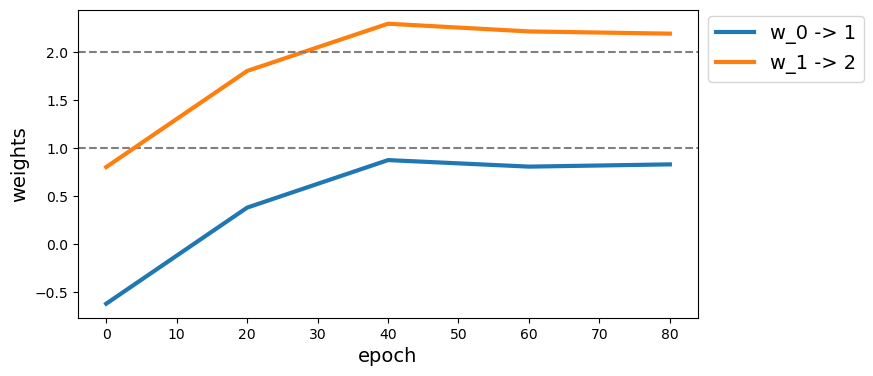

In [282]:
Conv1D_Fit_and_PlotWeights(model=model_cnn, X=X, y=y, epochs=100, n_weights=2)

In [283]:
model_cnn.weights

## ▶ Rest_YN = 0
## PAJU
# array([[[1.7213565]], [[1.2665269]]], dtype=float32)>
## BUNDANG
# array([[[1.0229897]], [[1.954732 ]]], dtype=float32)>
## KANGNAM
# array([[[2.4775867 ]], [[0.51914614]]], dtype=float32)>]
## CHEONGJU
# array([[[0.62315595]], [[2.3785403 ]]], dtype=float32)>
## DAEGU
# array([[[0.8612089]], [[2.1383426]]], dtype=float32)>

## ▶ Rest_YN = 1
## PAJU
# array([[[0.8258135]], [[2.1827574]]], dtype=float32)>
## BUNDANG
# array([[[1.0900792]], [[1.8988266]]], dtype=float32)>
## KANGNAM
# array([[[0.66091853]], [[2.3377523 ]]], dtype=float32)>]
## CHEONGJU
# array([[[0.9945771]], [[1.9972475]]], dtype=float32)>
## DAEGU
# array([[[1.3062937]], [[1.7035362]]], dtype=float32)>


[<tf.Variable 'c1d/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
 array([[[0.8612089]],
 
        [[2.1383426]]], dtype=float32)>]